In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.signal import firwin, lfilter

## IMPORT CSV File ##

In [24]:
df = pd.read_csv('ppg_signal_emu.csv', sep = ';' )
filtered_signal = df['filtered_signal'].to_numpy()
time           = df['Timestamp'].to_numpy()
ppg_input       = df['adc_raw'].to_numpy()

In [25]:
fs_jscope = 1000   # Hz depends on JScope generated csv
fs_mcu    = 100    # Hz ADC Sampling

decim = fs_jscope // fs_mcu  # = 90


In [26]:

time = np.arange(len(filtered_signal)) / fs_jscope

## CUTTING SIGNAL ##

In [27]:
diff = np.abs(np.diff(filtered_signal))
threshold = np.mean(diff) * 3
active_idx = np.where(diff > threshold)[0]
start = active_idx[0]
end = active_idx[-1]

In [35]:
acquisition_time = (end-start)/1000
print(f'Time elapsed during simulation: {acquisition_time} s')

Time elapsed during simulation: 30.735 s


In [28]:
time_cut = time[start:end]
filtered_cut = filtered_signal[start:end]
adc_raw_cut = ppg_input[start:end]

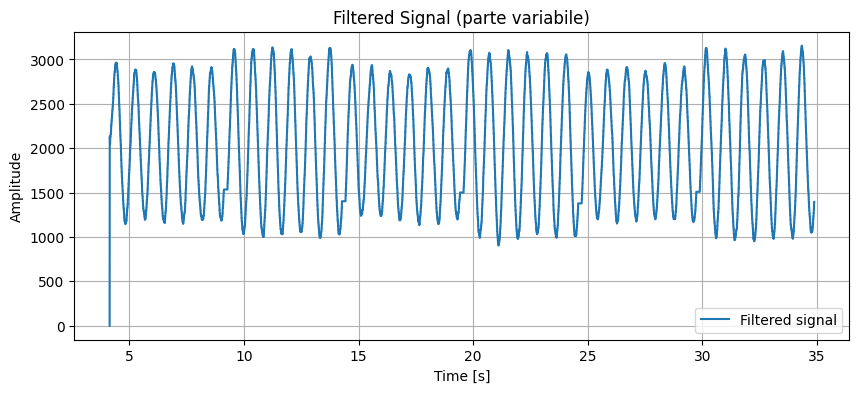

In [33]:

plt.figure(figsize=(10,4))
plt.plot(time_cut, filtered_cut, label="Filtered signal")#, plt.xlim(start), plt.xlim(end)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Filtered Signal (parte variabile)")
plt.grid(True)
plt.legend()
plt.show()


### INPUT SIGNAL ###

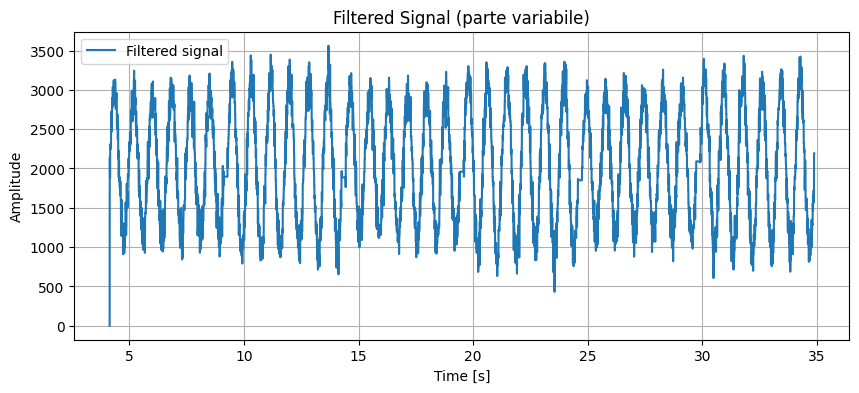

In [30]:
plt.figure(figsize=(10,4))
plt.plot(time_cut, adc_raw_cut, label="Filtered signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Filtered Signal (parte variabile)")
plt.grid(True)
plt.legend()
plt.show()
